### Introduction:

The aim of this notebook is to develop a DNN that can deterine if a satellite image is of an urban or rural area.

Dataset from http://madm.dfki.de/files/sentinel/EuroSAT.zip sentinel images and labels. The dataset has color images of 64 x 64, with a variety of categories:
<pre>
AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River  SeaLake
Forest      Highway               Pasture     Residential    
</pre>
The categories: AnnualCrop  HerbaceousVegetation PermanentCrop Forest Pasture were collapsed into a 'rural' category (n=13500) and the categories: Industrial and Residential were collapsed into an 'urban' category (n=5500). The urban category was then upsampled to obtain 13500 images (2 copies of the original 5500, and then a random sample of 2500 from the original urban images).

A model from the tensorflow hub was chosen which has been pretrained on eurosat satellite data: https://tfhub.dev/google/collections/remote_sensing/1 . As it is a hub model and not a tensorflow application, it is not possible to fine tune the model, only to build on top of it but the model generated seems to give good performance when shown images it has not been seen before (accuracy of around 98%).  

If greater performance is required, maybe then a different model can be made using a tensorflow application such as resnet and then after the training of the added top layers, the entire model can be fine tuned using a low learning rate to the specific training images. 

When a prediction was run on all testing images, the following confusion matrix was produced:
<pre>
                 predicted
             rural  urban
true:  rural 1350   25
       urban 15    1058
 </pre>
 signifying a model with relatively good performance. 
 
### Usage:
The zip file contains the train/valid/test images used in this notebook, as well as the model checkpoint with the best performing weights. Download and extract the files and then run this notebook with the files in the same working directory.

In [1]:
# Import the tensorflow libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.preprocessing.image as kp
import tensorflow_hub as hub

#file management
import os
from os import getcwd

# Import visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn

# Other libraries
import random
import numpy as np
from sklearn.metrics import confusion_matrix



### Preprocessing:

First we get a feel for the images in each category:

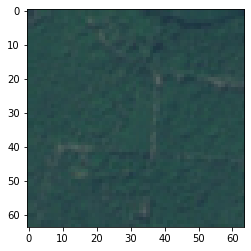

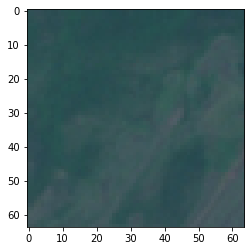

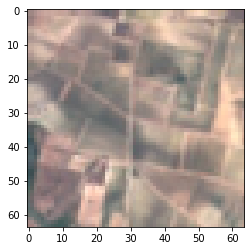

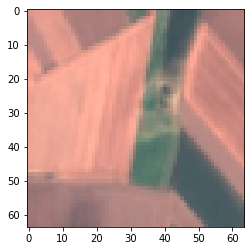

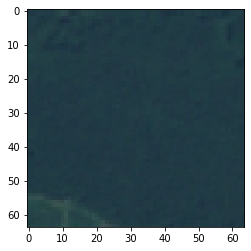

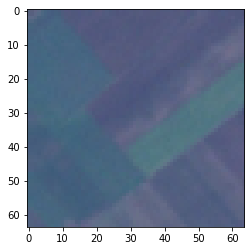

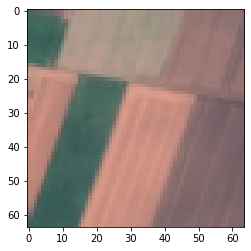

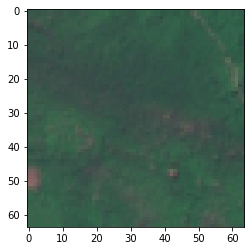

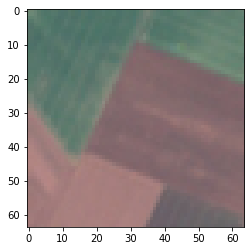

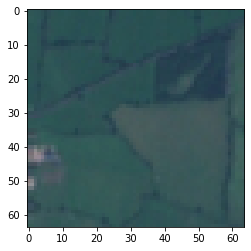

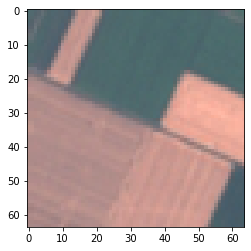

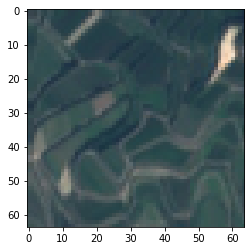

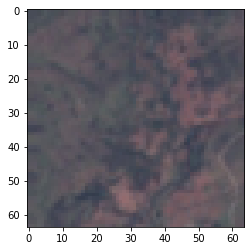

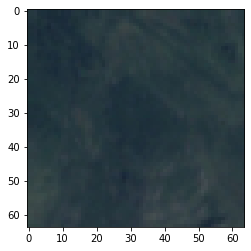

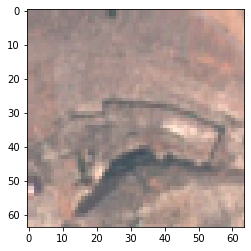

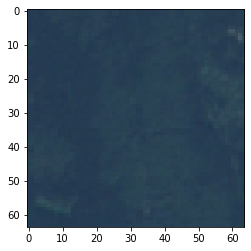

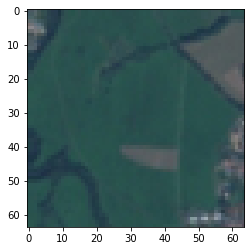

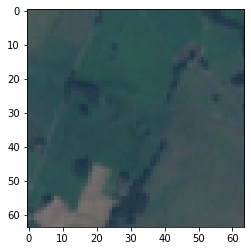

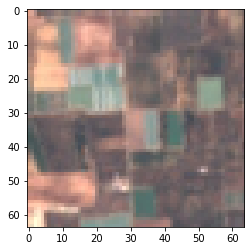

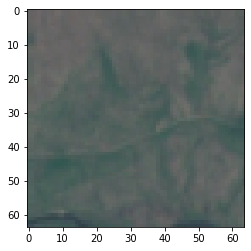

In [2]:
#look at rural images
work_dir = os.getcwd()
image_dir_rural = os.path.join(work_dir,'area_type_pics/train/rural')
images = os.listdir(image_dir_rural)
files_to_show = random.sample(images,20)
for file in files_to_show:
        img_path = os.path.join(image_dir_rural,file)
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()


    

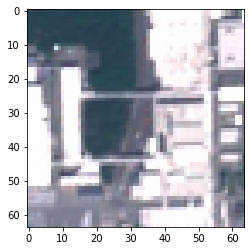

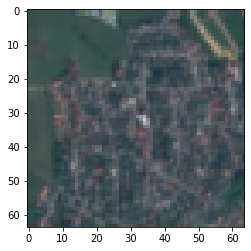

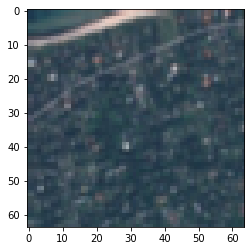

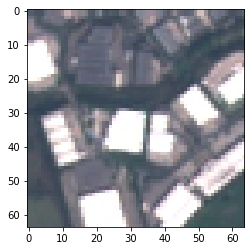

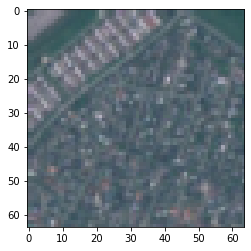

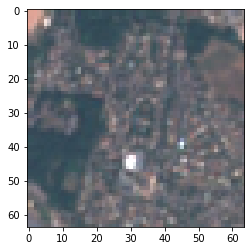

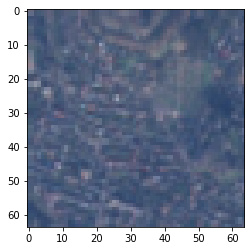

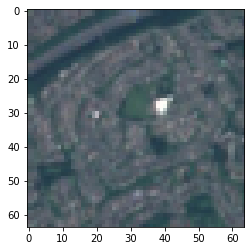

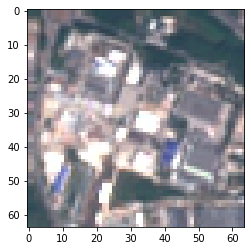

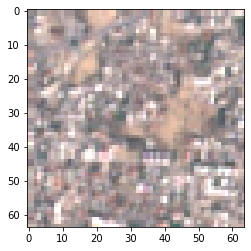

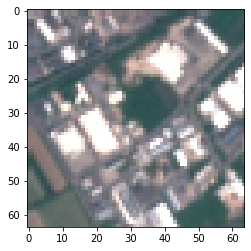

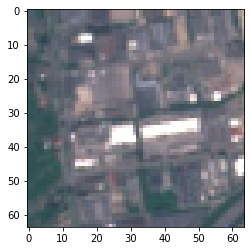

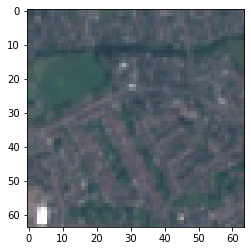

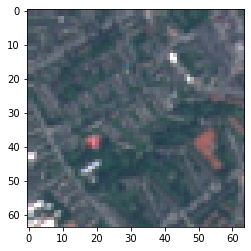

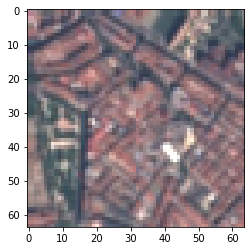

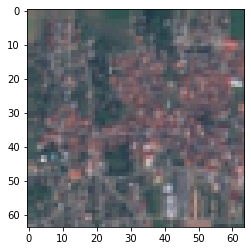

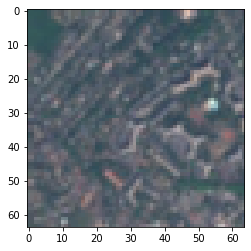

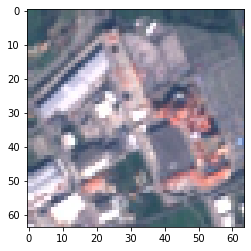

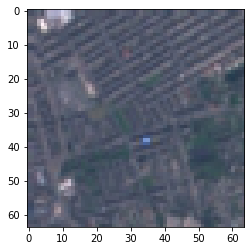

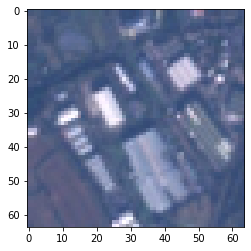

In [3]:
#look at urban images
image_dir_urban = os.path.join(work_dir,'area_type_pics/train/urban')
images = os.listdir(image_dir_urban)
files_to_show = random.sample(images,20)
for file in files_to_show:
        img_path = os.path.join(image_dir_urban,file)
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.show()

In [4]:
#set relevant directories containing the images
train_dir = 'area_type_pics/train'
valid_dir = 'area_type_pics/valid'
test_dir = 'area_type_pics/test'

#set up image pipelines

training_datagen = ImageDataGenerator(
      #rescale = 1./255,
      rotation_range=30,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

#specify the data generators to feed in the validation and testing images
validation_datagen = ImageDataGenerator()#rescale = 1./255)
testing_datagen = ImageDataGenerator()#rescale = 1./255)

#create generator objects for image pipeline
train_generator = training_datagen.flow_from_directory(
    train_dir,
    shuffle = True,
    #target_size=(64,64),
    class_mode='binary',
    batch_size=64)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    #target_size=(64,64),
    class_mode='binary',
    shuffle = True,
    batch_size=64)

testing_generator = testing_datagen.flow_from_directory(
    test_dir,
    #target_size=(64,64),
    class_mode='binary',
    batch_size=64)

Found 19611 images belonging to 2 classes.
Found 2441 images belonging to 2 classes.
Found 2448 images belonging to 2 classes.


### Define and train the model:

In [5]:
#set expected image size
IMAGE_SIZE= (64, 64)
#set url of pretrained model
model_url = "https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1"
pt_layers = hub.KerasLayer(model_url,trainable=False) #load pretrained model

#build neural network
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(height = 64, width = 64),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    hub.KerasLayer("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1",trainable=False), # pretrained model
    tf.keras.layers.Dropout(rate=0.2), #add drop outs to reduce impact of specific neurons
    tf.keras.layers.Dense(512, activation='relu'), # add final layers
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'), # output binary classifer, outputs 0 for rural and 1 for urban
    #tf.keras.layers.Lambda(lambda x: x+1) #encodes into irap encoding 1 = rural, 
    ])

In [7]:
#set path for model checkpoints
checkpoint_path = "cp_area_type.ckpt"
checkpoint_dir = os.path.join(work_dir,checkpoint_path)

# Create a callback that saves the model's weights based on best value for validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                                 save_best_only = True,
                                                 filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=0)
#create another callback for early stopping and assign both callbacks to variable:
callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

callbacks = [cp_callback,callback2]

In [8]:
#compile model 
optim_a = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=['binary_accuracy']) 

#load best weights from model so far
model.load_weights(checkpoint_dir)
#create a history of the model to evaluate current training progress and performance, then fit model
history = model.fit(train_generator,
                    epochs=10, 
                    steps_per_epoch=5, 
                    validation_data = validation_generator,
                    validation_freq = 1,
                    verbose = 1, 
                    validation_steps=1,
                    callbacks = callbacks)

Epoch 1/10
5/5 [==============================] - 56s 11s/step - loss: 0.0517 - binary_accuracy: 0.9812 - val_loss: 0.0490 - val_binary_accuracy: 0.9688
Epoch 2/10
5/5 [==============================] - 50s 10s/step - loss: 0.0419 - binary_accuracy: 0.9812 - val_loss: 0.1771 - val_binary_accuracy: 0.9219
Epoch 3/10
5/5 [==============================] - 55s 11s/step - loss: 0.1028 - binary_accuracy: 0.9719 - val_loss: 0.1542 - val_binary_accuracy: 0.9531
Epoch 4/10
5/5 [==============================] - 56s 11s/step - loss: 0.0406 - binary_accuracy: 0.9906 - val_loss: 0.0228 - val_binary_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 65s 13s/step - loss: 0.0718 - binary_accuracy: 0.9781 - val_loss: 0.0183 - val_binary_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 62s 12s/step - loss: 0.0453 - binary_accuracy: 0.9812 - val_loss: 0.0124 - val_binary_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 62s 12s/step - loss: 0.0393 - bi

### Model evaluation:

Now we will evaluate the model:

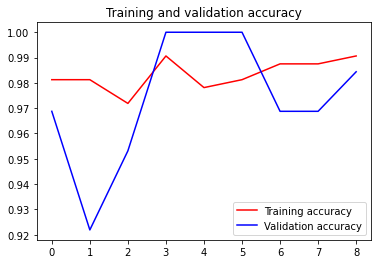

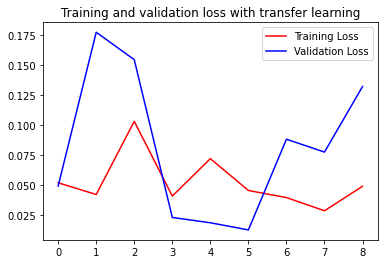

max valid accuracy: 1.0


In [9]:
# get performance metrics from history variable 
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plot performance graphs
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss with transfer learning')
plt.legend()

plt.show()

print('max valid accuracy: {}'.format(max(val_acc)))

In [10]:
#evaluate performance of the model on classifying the unseen testing images

eval_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=4,min_delta=0.01, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

model.evaluate(testing_generator,
    steps=10, #can be increased for more detailed analysis of model accuracy
    callbacks=[eval_callback],
    max_queue_size=10,
    workers=2,
    verbose=1)

# outputs loss and accuracy when the model is tested on unseen test images

10/10 [==============================] - 95s 9s/step - loss: 0.0374 - binary_accuracy: 0.9875


[0.03737187013030052, 0.987500011920929]

Now we will use the model to make some predictions and see how it performs:

In [15]:
# get testing labels and filepaths from the image generators
testing_labels = testing_generator.labels
testing_filepaths = testing_generator.filepaths
indexes_to_take = np.random.choice(range(len(testing_filepaths)),100) #take a sample, set n to samples to take, n = 2448 for predictions on all test images
testing_labels_sample = np.take(testing_labels,indexes_to_take) 
testing_filepaths_sample = np.take(testing_filepaths,indexes_to_take)

#now we will loop through the testing images and make a prediction for each one
predicts = []
for filepath in testing_filepaths_sample:
    temp = kp.load_img(filepath,target_size=(64,64,3))
    array = kp.img_to_array(temp)
    array_stan = array/255.0 #scale
    array_shaped = np.expand_dims(array_stan,axis=0) #get to same dimensions the model is expecting
    predict = (model.predict(x) > 0.5).astype("int32") #predict class label and return single value not np array
    predicts.append(predict)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


file:  area_type_pics/test/urban/Residential_220 (1).jpg
Image label : 1
Predicted label :1


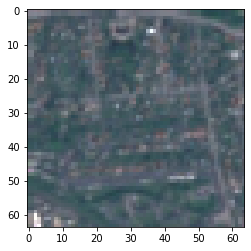

file:  area_type_pics/test/rural/HerbaceousVegetation_2956.jpg
Image label : 0
Predicted label :0


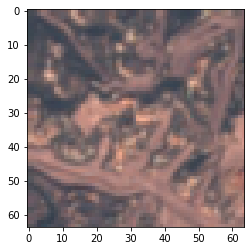

file:  area_type_pics/test/urban/Industrial_1672.jpg
Image label : 1
Predicted label :1


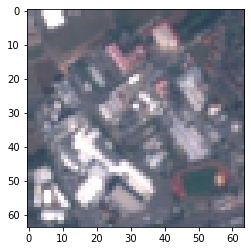

file:  area_type_pics/test/rural/AnnualCrop_254.jpg
Image label : 0
Predicted label :0


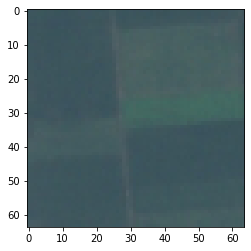

file:  area_type_pics/test/rural/HerbaceousVegetation_377.jpg
Image label : 0
Predicted label :0


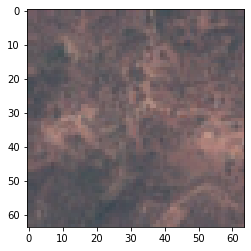

file:  area_type_pics/test/rural/AnnualCrop_1523.jpg
Image label : 0
Predicted label :0


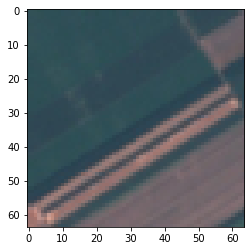

file:  area_type_pics/test/rural/AnnualCrop_2792.jpg
Image label : 0
Predicted label :0


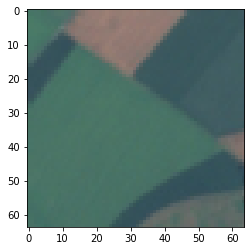

file:  area_type_pics/test/urban/Residential_1893 (1).jpg
Image label : 1
Predicted label :1


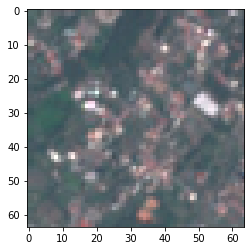

file:  area_type_pics/test/urban/Industrial_719.jpg
Image label : 1
Predicted label :1


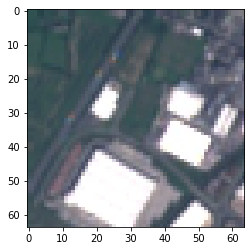

file:  area_type_pics/test/urban/Residential_2241 (1).jpg
Image label : 1
Predicted label :1


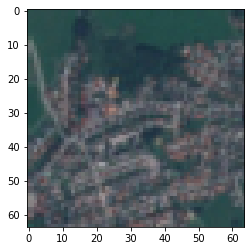

file:  area_type_pics/test/urban/Industrial_681 (1).jpg
Image label : 1
Predicted label :1


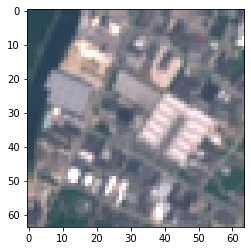

file:  area_type_pics/test/urban/Residential_170.jpg
Image label : 1
Predicted label :1


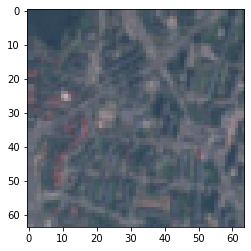

file:  area_type_pics/test/urban/Industrial_469.jpg
Image label : 1
Predicted label :1


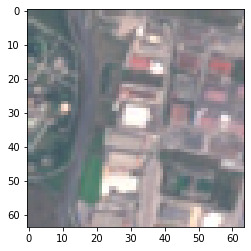

file:  area_type_pics/test/urban/Residential_1022 (1).jpg
Image label : 1
Predicted label :1


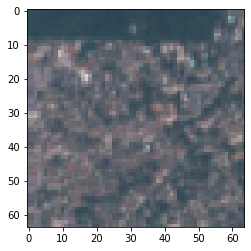

file:  area_type_pics/test/urban/Residential_965.jpg
Image label : 1
Predicted label :1


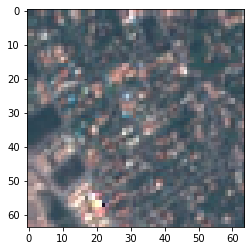

file:  area_type_pics/test/urban/Industrial_2057.jpg
Image label : 1
Predicted label :1


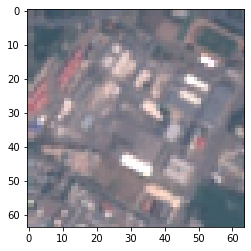

file:  area_type_pics/test/rural/AnnualCrop_1461.jpg
Image label : 0
Predicted label :0


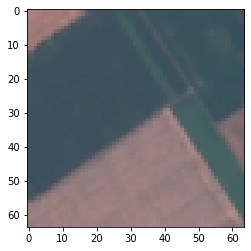

file:  area_type_pics/test/rural/PermanentCrop_2326.jpg
Image label : 0
Predicted label :0


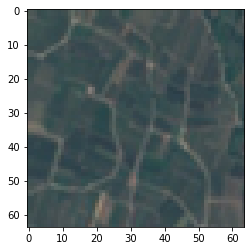

file:  area_type_pics/test/rural/Forest_928.jpg
Image label : 0
Predicted label :0


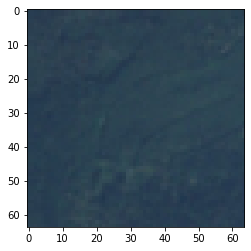

file:  area_type_pics/test/urban/Residential_167 (1).jpg
Image label : 1
Predicted label :1


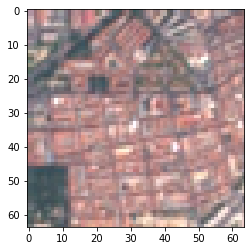

file:  area_type_pics/test/urban/Industrial_2227 (1).jpg
Image label : 1
Predicted label :1


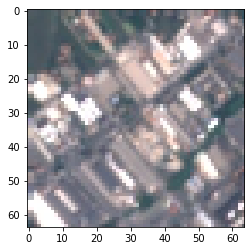

file:  area_type_pics/test/rural/PermanentCrop_474.jpg
Image label : 0
Predicted label :0


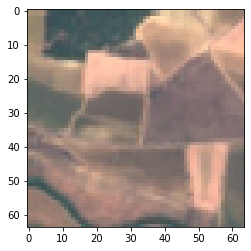

file:  area_type_pics/test/urban/Residential_86 (1).jpg
Image label : 1
Predicted label :1


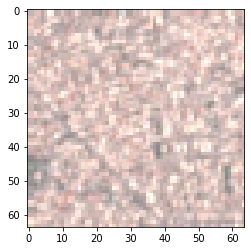

file:  area_type_pics/test/urban/Industrial_1517.jpg
Image label : 1
Predicted label :1


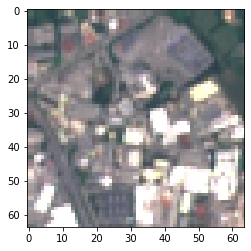

file:  area_type_pics/test/rural/Forest_196.jpg
Image label : 0
Predicted label :0


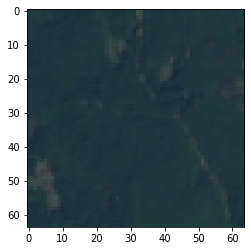

file:  area_type_pics/test/urban/Residential_2690 (1).jpg
Image label : 1
Predicted label :1


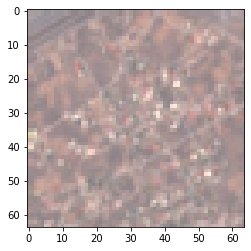

file:  area_type_pics/test/urban/Industrial_158.jpg
Image label : 1
Predicted label :1


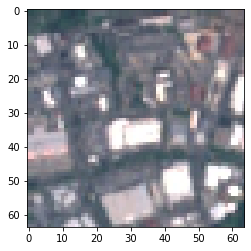

file:  area_type_pics/test/rural/Forest_1569.jpg
Image label : 0
Predicted label :0


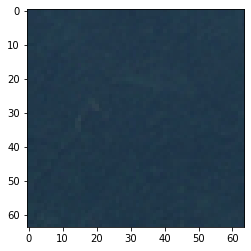

file:  area_type_pics/test/urban/Residential_2197 (1).jpg
Image label : 1
Predicted label :1


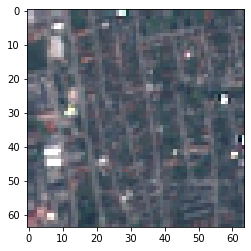

file:  area_type_pics/test/rural/Pasture_1447.jpg
Image label : 0
Predicted label :0


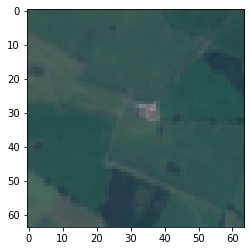

file:  area_type_pics/test/urban/Industrial_2206.jpg
Image label : 1
Predicted label :1


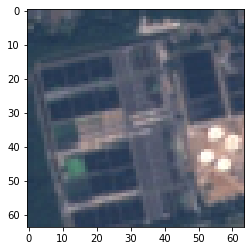

file:  area_type_pics/test/rural/AnnualCrop_1687.jpg
Image label : 0
Predicted label :0


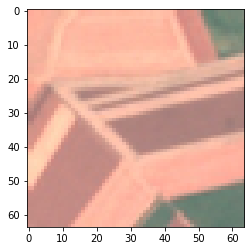

file:  area_type_pics/test/urban/Residential_1538.jpg
Image label : 1
Predicted label :1


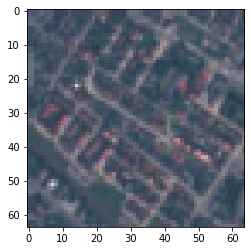

file:  area_type_pics/test/urban/Industrial_2361.jpg
Image label : 1
Predicted label :1


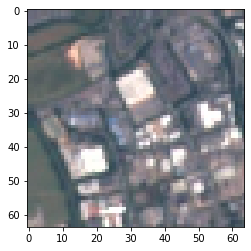

file:  area_type_pics/test/urban/Residential_2699.jpg
Image label : 1
Predicted label :1


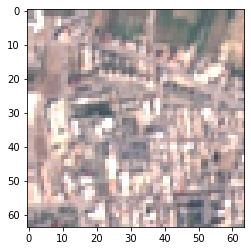

file:  area_type_pics/test/rural/Forest_2804.jpg
Image label : 0
Predicted label :0


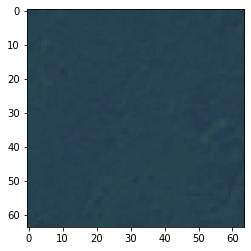

file:  area_type_pics/test/rural/Forest_1014.jpg
Image label : 0
Predicted label :0


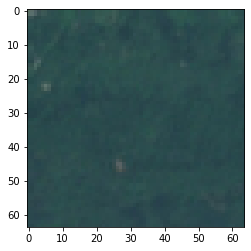

file:  area_type_pics/test/urban/Residential_2021 (1).jpg
Image label : 1
Predicted label :1


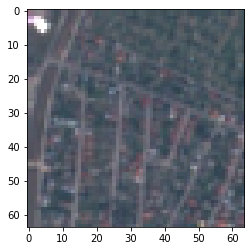

file:  area_type_pics/test/rural/Forest_1809.jpg
Image label : 0
Predicted label :0


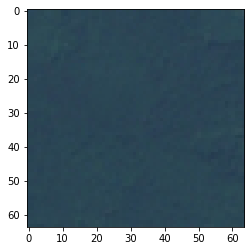

file:  area_type_pics/test/rural/HerbaceousVegetation_493.jpg
Image label : 0
Predicted label :0


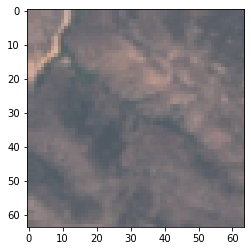

file:  area_type_pics/test/urban/Industrial_437 (1).jpg
Image label : 1
Predicted label :1


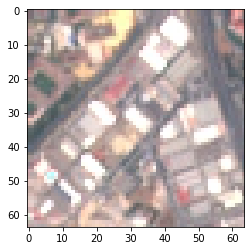

file:  area_type_pics/test/rural/Pasture_1481.jpg
Image label : 0
Predicted label :0


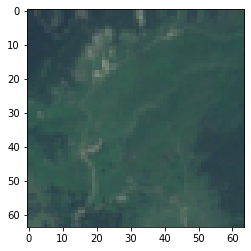

file:  area_type_pics/test/urban/Residential_2992.jpg
Image label : 1
Predicted label :1


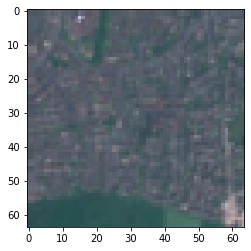

file:  area_type_pics/test/rural/HerbaceousVegetation_2825.jpg
Image label : 0
Predicted label :0


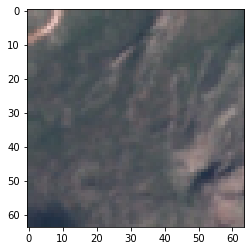

file:  area_type_pics/test/urban/Industrial_316 (1).jpg
Image label : 1
Predicted label :1


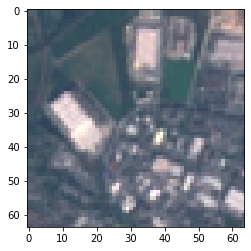

file:  area_type_pics/test/rural/PermanentCrop_2010.jpg
Image label : 0
Predicted label :0


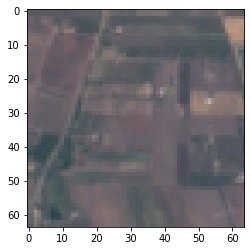

file:  area_type_pics/test/urban/Industrial_51.jpg
Image label : 1
Predicted label :1


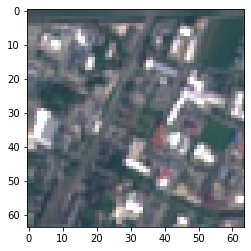

file:  area_type_pics/test/urban/Residential_1554 (1).jpg
Image label : 1
Predicted label :1


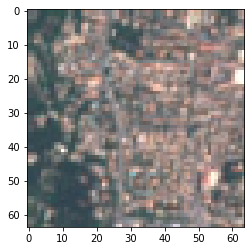

file:  area_type_pics/test/rural/PermanentCrop_144.jpg
Image label : 0
Predicted label :0


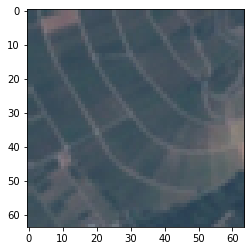

file:  area_type_pics/test/urban/Industrial_99 (1).jpg
Image label : 1
Predicted label :1


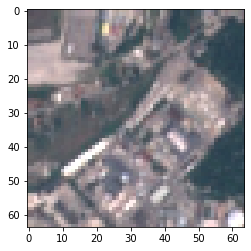

file:  area_type_pics/test/urban/Residential_2863.jpg
Image label : 1
Predicted label :1


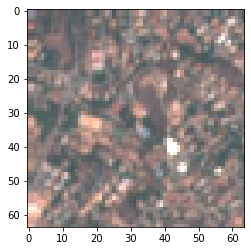

file:  area_type_pics/test/urban/Industrial_1660.jpg
Image label : 1
Predicted label :1


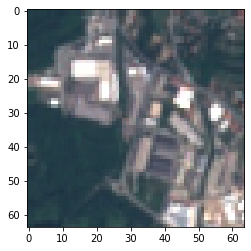

file:  area_type_pics/test/urban/Residential_481.jpg
Image label : 1
Predicted label :1


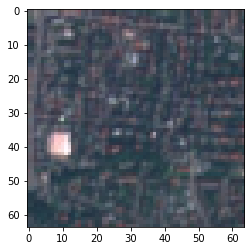

file:  area_type_pics/test/urban/Residential_2133.jpg
Image label : 1
Predicted label :1


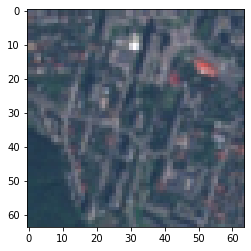

file:  area_type_pics/test/rural/Pasture_807.jpg
Image label : 0
Predicted label :0


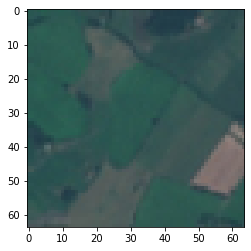

file:  area_type_pics/test/urban/Industrial_1517.jpg
Image label : 1
Predicted label :1


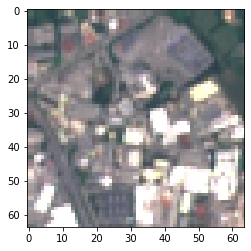

file:  area_type_pics/test/rural/AnnualCrop_138.jpg
Image label : 0
Predicted label :0


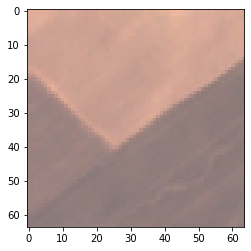

file:  area_type_pics/test/rural/PermanentCrop_1480.jpg
Image label : 0
Predicted label :0


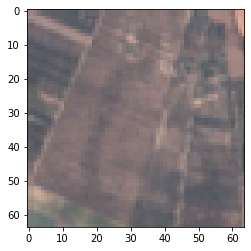

file:  area_type_pics/test/urban/Residential_471 (1).jpg
Image label : 1
Predicted label :1


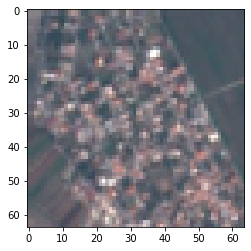

file:  area_type_pics/test/rural/PermanentCrop_1819.jpg
Image label : 0
Predicted label :0


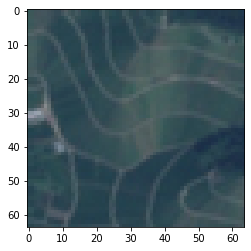

file:  area_type_pics/test/urban/Residential_2794.jpg
Image label : 1
Predicted label :1


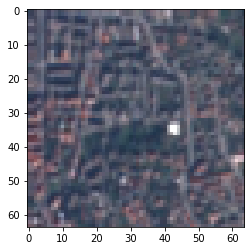

file:  area_type_pics/test/rural/PermanentCrop_1739.jpg
Image label : 0
Predicted label :0


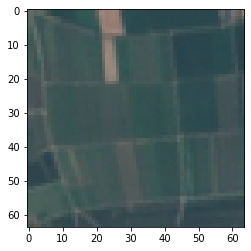

file:  area_type_pics/test/urban/Residential_385.jpg
Image label : 1
Predicted label :1


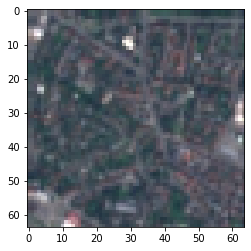

file:  area_type_pics/test/rural/AnnualCrop_2281.jpg
Image label : 0
Predicted label :0


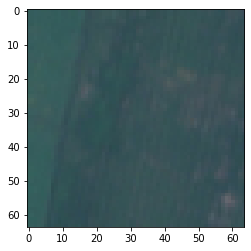

file:  area_type_pics/test/urban/Industrial_1549.jpg
Image label : 1
Predicted label :1


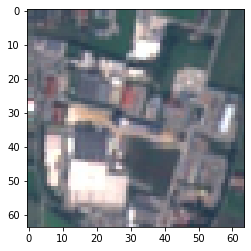

file:  area_type_pics/test/urban/Industrial_158.jpg
Image label : 1
Predicted label :1


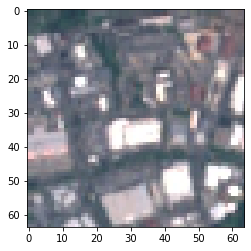

file:  area_type_pics/test/rural/Forest_2342.jpg
Image label : 0
Predicted label :0


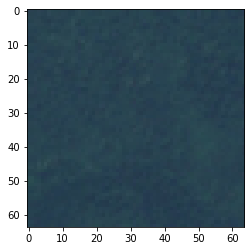

file:  area_type_pics/test/rural/Forest_782.jpg
Image label : 0
Predicted label :0


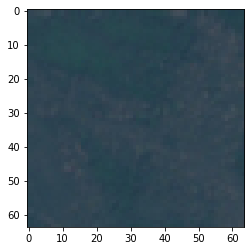

file:  area_type_pics/test/urban/Residential_383 (1).jpg
Image label : 1
Predicted label :1


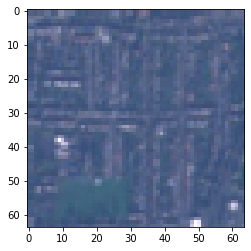

file:  area_type_pics/test/urban/Industrial_701 (1).jpg
Image label : 1
Predicted label :1


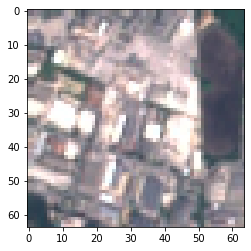

file:  area_type_pics/test/rural/PermanentCrop_1500.jpg
Image label : 0
Predicted label :0


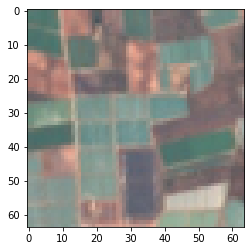

file:  area_type_pics/test/rural/PermanentCrop_1704.jpg
Image label : 0
Predicted label :0


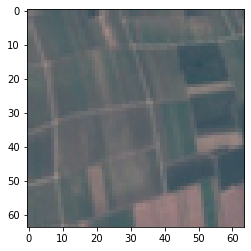

file:  area_type_pics/test/rural/AnnualCrop_1569.jpg
Image label : 0
Predicted label :0


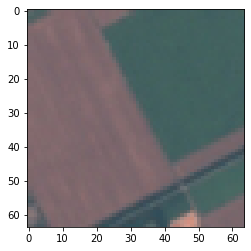

file:  area_type_pics/test/urban/Industrial_1433 (1).jpg
Image label : 1
Predicted label :1


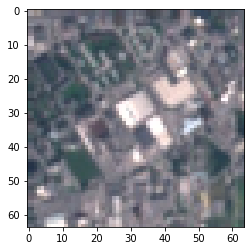

file:  area_type_pics/test/rural/AnnualCrop_2273.jpg
Image label : 0
Predicted label :0


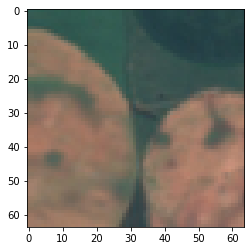

file:  area_type_pics/test/rural/AnnualCrop_2571.jpg
Image label : 0
Predicted label :0


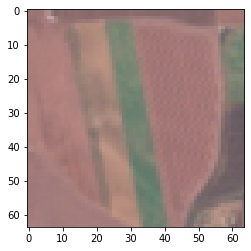

file:  area_type_pics/test/rural/HerbaceousVegetation_621.jpg
Image label : 0
Predicted label :0


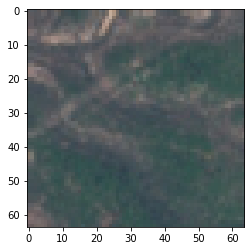

file:  area_type_pics/test/rural/HerbaceousVegetation_1892.jpg
Image label : 0
Predicted label :0


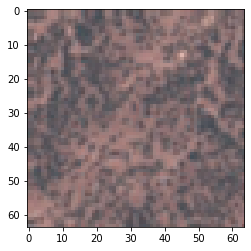

file:  area_type_pics/test/urban/Residential_2653.jpg
Image label : 1
Predicted label :1


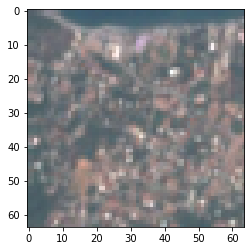

file:  area_type_pics/test/rural/Pasture_1358.jpg
Image label : 0
Predicted label :0


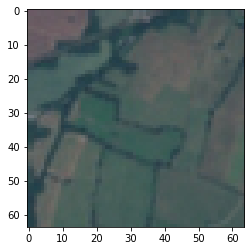

file:  area_type_pics/test/rural/Pasture_1865.jpg
Image label : 0
Predicted label :0


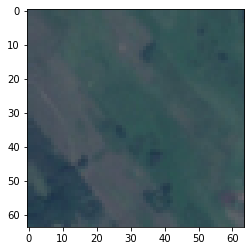

file:  area_type_pics/test/urban/Residential_2021 (1).jpg
Image label : 1
Predicted label :1


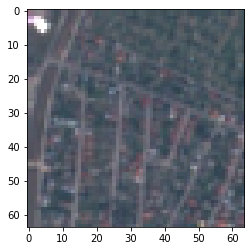

file:  area_type_pics/test/rural/PermanentCrop_274.jpg
Image label : 0
Predicted label :0


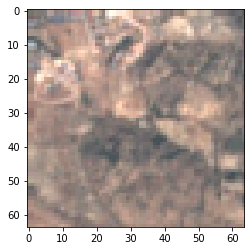

file:  area_type_pics/test/rural/AnnualCrop_2316.jpg
Image label : 0
Predicted label :0


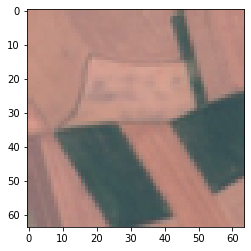

file:  area_type_pics/test/urban/Residential_2967 (1).jpg
Image label : 1
Predicted label :1


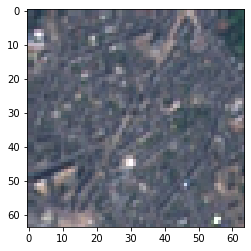

file:  area_type_pics/test/rural/Forest_331.jpg
Image label : 0
Predicted label :0


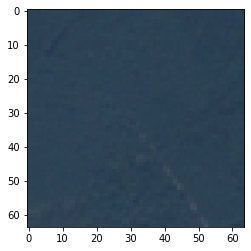

file:  area_type_pics/test/urban/Industrial_2121.jpg
Image label : 1
Predicted label :1


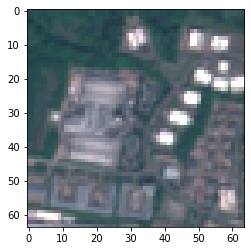

file:  area_type_pics/test/rural/HerbaceousVegetation_696.jpg
Image label : 0
Predicted label :0


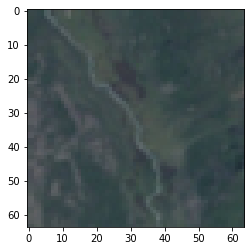

file:  area_type_pics/test/urban/Residential_1353 (1).jpg
Image label : 1
Predicted label :1


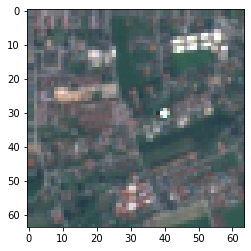

file:  area_type_pics/test/urban/Industrial_1384 (1).jpg
Image label : 1
Predicted label :1


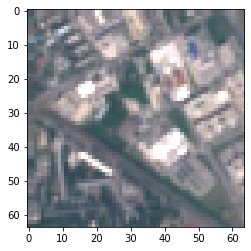

file:  area_type_pics/test/urban/Residential_13 (1).jpg
Image label : 1
Predicted label :1


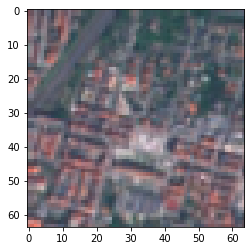

file:  area_type_pics/test/rural/HerbaceousVegetation_2504.jpg
Image label : 0
Predicted label :0


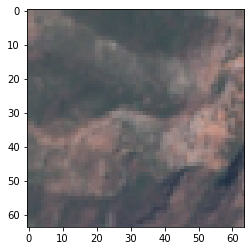

file:  area_type_pics/test/urban/Residential_1921.jpg
Image label : 1
Predicted label :1


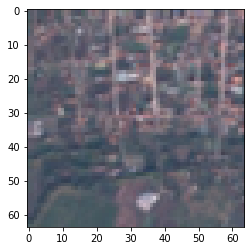

file:  area_type_pics/test/rural/HerbaceousVegetation_1949.jpg
Image label : 0
Predicted label :0


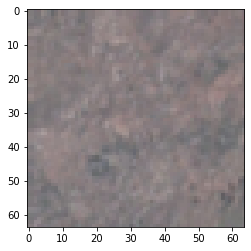

file:  area_type_pics/test/urban/Residential_1295 (1).jpg
Image label : 1
Predicted label :1


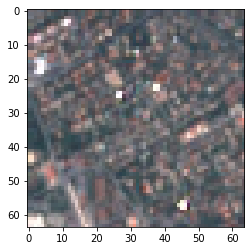

file:  area_type_pics/test/urban/Industrial_719 (1).jpg
Image label : 1
Predicted label :1


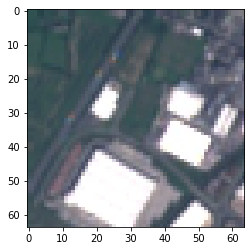

file:  area_type_pics/test/rural/HerbaceousVegetation_126.jpg
Image label : 0
Predicted label :0


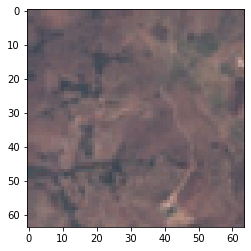

file:  area_type_pics/test/rural/Pasture_44.jpg
Image label : 0
Predicted label :0


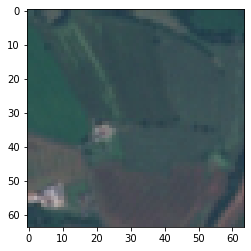

file:  area_type_pics/test/rural/Forest_53.jpg
Image label : 0
Predicted label :0


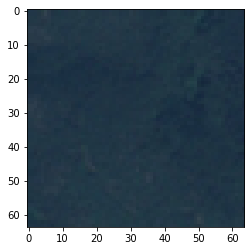

file:  area_type_pics/test/urban/Residential_1713 (1).jpg
Image label : 1
Predicted label :1


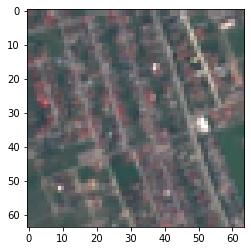

In [96]:
#loop through some images and display the label, prediction, image location and image:
for x in range(len(testing_filepaths_sample)): 
    print('file: ',testing_filepaths_sample[x])
    print('Image label : {}'.format(testing_labels_sample[x]))
    print('Predicted label :{}'.format(predicts[x]))
    img = mpimg.imread(testing_filepaths_sample[x])
    imgplot = plt.imshow(img)
    plt.show()

[[1350   25]
 [  15 1058]]


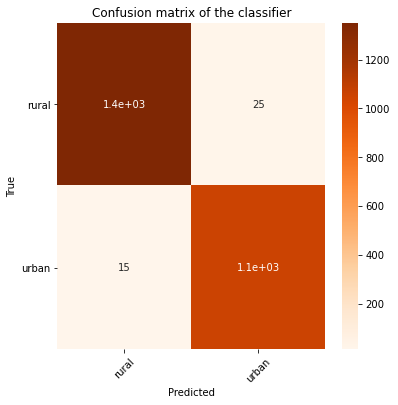

In [16]:
#check confusion matrix to see how model is performing
cm = confusion_matrix(testing_labels_sample, predicts)
print(cm)
#make more readable confusion matrix
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.title('Confusion matrix of the classifier')
seaborn.heatmap(cm,annot=True,cmap='Oranges')
labels = ['rural','urban']
ax.set_xticklabels(labels,rotation=45)
ax.set_yticklabels(labels,rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
save_path = os.path.join(work_dir,'area_type_urban_vs_rural_model.h5')
tf.keras.models.save_model(model,filepath = save_path,include_optimizer=True, 
                           save_format='h5')
